In [6]:
# https://www.tensorflow.org/decision_forests/tutorials/beginner_colab
# https://www.tensorflow.org/decision_forests/tutorials/predict_colab
# https://www.tensorflow.org/decision_forests/tutorials/automatic_tuning_colab
# https://www.tensorflow.org/decision_forests/tutorials/advanced_colab 

from google.cloud import bigquery
#! pip install google-cloud-bigquery --user

import pandas as pd
import numpy as np

import math
import os

import tensorflow as tf
print(tf.__version__)

2.12.0


In [29]:
#pip install tensorflow_decision_forests --upgrade --user
import tensorflow_decision_forests as tfdf
print(tfdf.__version__)

1.4.0


# Variable to Configuration

In [30]:
model_tree_type=2# 1= xgboost  2-random forest
option=2 

labelCol='label_multi_severity'
# labelCol='label_binary_severity'

In [31]:
projectId='pongthorn'
dataset_id='SMartML'

train_name='train2_incident'
test_name='test2_incident'

train_table_id=f"{projectId}.{dataset_id}.{train_name}"
test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"
print(f"train-ds = {train_table_id}")
print(f"test-ds = {test_tabel_id}")

train-ds = pongthorn.SMartML.train2_incident
test-ds = pongthorn.SMartML.test2_incident


In [32]:
metric="accuracy"

if model_tree_type==1:
    _model='model_xgb_tf'
else:
     _model='model_rf_tf'

model_gs_path=f"gs://demo-tuned-tf-incident-pongthorn/{_model}"
print(model_gs_path)
#model_local_path=_model

gs://demo-tuned-tf-incident-pongthorn/model_rf_tf


In [33]:

if option==1:
    # cateCols=['sla','product_type','brand','service_type','incident_type','range_open_to_close_hour','range_response_to_resolved_hour']
    cateCols=['sla','product_type','brand','service_type','incident_type','range_open_to_close_hour']
    numbericCols=[]
    #unusedCols=['id','severity_id','severity_name','label_binary_severity','open_to_close_hour','response_to_resolved_hour']
    unusedCols=['id','severity_id','severity_name','label_binary_severity','open_to_close_hour']
else:
    cateCols=['sla','product_type','brand','service_type','incident_type']
    numbericCols=['open_to_close_hour']
    unusedCols=['id','severity_id','severity_name','label_binary_severity','range_open_to_close_hour']




# Load & Prepare Data

In [34]:
def load_ml_data(data_path):
 df=pd.read_csv(data_path)
 df =df.drop(columns=unusedCols)
 
 return df

def load_data_bq(sql:str):
 
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 df =df.drop(columns=unusedCols)
 df[labelCol]=df[labelCol].astype('int64') 
 df=df[[labelCol]+cateCols+numbericCols]   
  
 return df

In [35]:
client = bigquery.Client(project=projectId)

train=load_data_bq(f"SELECT * FROM {train_table_id}")
test=load_data_bq(f"SELECT * FROM {test_tabel_id}")

print(train.info())

print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2241 entries, 0 to 2240
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   label_multi_severity  2241 non-null   int64  
 1   sla                   2241 non-null   object 
 2   product_type          2241 non-null   object 
 3   brand                 2241 non-null   object 
 4   service_type          2241 non-null   object 
 5   incident_type         2241 non-null   object 
 6   open_to_close_hour    2241 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 122.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   label_multi_severity  561 non-null    int64  
 1   sla                   561 non-null    object 
 2   product_type          561 non-null    object 
 3   br

In [36]:
classes_train = list(train[labelCol].unique())
classes_test = list(test[labelCol].unique())

set_classes=set(classes_train) & set(classes_test)
classes=list(set_classes)
classes

[0, 1, 2, 3]

In [37]:
train.tail(5)

,label_multi_severity,sla,product_type,brand,service_type,incident_type,open_to_close_hour
2236,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,Configuration Change,5.516667
2237,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,OS / Firmware,1193.283333
2238,0,24x7 6Hrs Resolution Time,Software,Trend Micro,Request,General Incident,0.883333
2239,0,24x7 4Hrs Response Time,Security,Trend Micro,Request,Upgrade Software,264.950000
2240,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,21.333333


In [38]:
test.tail()

,label_multi_severity,sla,product_type,brand,service_type,incident_type,open_to_close_hour
556,0,24x7 4Hrs Resolution Time,Firewall,Palo Alto,Request,Software,579.850000
557,3,24x7 6Hrs Resolution Time,Software,Trend Micro,Incident,General Incident,13.316667
558,1,24x7 4Hrs Response Time,Software,Trend Micro,Request,Software,360.800000
559,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,163.850000
560,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,96.483333


# Build Model

In [39]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label=labelCol)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label=labelCol)

In [40]:
# Specify the model.
if model_tree_type==1:
    print("GradientBoostedTreesModel")
    model=tfdf.keras.GradientBoostedTreesModel()
else:
    print("RandomForestModel")
    model = tfdf.keras.RandomForestModel()

model.fit(x=train_ds)

RandomForestModel
Use /var/tmp/tmpf8qmuiwl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.201497. Found 2241 examples.
Training model...


2023-07-06 11:19:25.059363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2241]
	 [[{{node Placeholder/_1}}]]
[INFO 23-07-06 11:19:27.4960 UTC kernel.cc:1243] Loading model from path /var/tmp/tmpf8qmuiwl/model/ with prefix e3168b6d1bdc44ce


Model trained in 0:00:02.727332
Compiling model...


[INFO 23-07-06 11:19:27.9478 UTC decision_forest.cc:660] Model loaded with 300 root(s), 140518 node(s), and 6 input feature(s).
[INFO 23-07-06 11:19:27.9487 UTC abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 23-07-06 11:19:27.9492 UTC kernel.cc:1075] Use fast generic engine
2023-07-06 11:19:28.024070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [2241]
	 [[{{node Placeholder/_4}}]]


Model compiled.


In [41]:
model.compile(metrics=[metric])
evaluation = model.evaluate(test_ds, return_dict=True)
for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 179ms/step - loss: 0.0000e+00 - accuracy: 0.7059


2023-07-06 11:19:30.376537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype int64 and shape [561]
	 [[{{node Placeholder/_6}}]]


loss: 0.0000
accuracy: 0.7059


# Model Summary
## Model structure and feature importance

In [42]:
#model_detail=model.summary()
model.make_inspector().variable_importances()
# SUM_SCORE ,NUM_AS_ROOT

{'NUM_NODES': [("open_to_close_hour" (1; #3), 46182.0),
  ("incident_type" (4; #2), 8466.0),
  ("brand" (4; #1), 6012.0),
  ("sla" (4; #6), 5281.0),
  ("product_type" (4; #4), 3636.0),
  ("service_type" (4; #5), 532.0)],
 'INV_MEAN_MIN_DEPTH': [("service_type" (4; #5), 0.6048752939390567),
  ("brand" (4; #1), 0.39951477908737937),
  ("incident_type" (4; #2), 0.26994189663248463),
  ("product_type" (4; #4), 0.17896700204644073),
  ("open_to_close_hour" (1; #3), 0.16551900977810027),
  ("sla" (4; #6), 0.153420325479277)],
 'SUM_SCORE': [("service_type" (4; #5), 171030.78093647212),
  ("open_to_close_hour" (1; #3), 164719.22510369655),
  ("brand" (4; #1), 98291.28125946628),
  ("incident_type" (4; #2), 80119.79267666285),
  ("product_type" (4; #4), 40413.15450172557),
  ("sla" (4; #6), 32552.685353374633)],
 'NUM_AS_ROOT': [("service_type" (4; #5), 191.0),
  ("brand" (4; #1), 88.0),
  ("product_type" (4; #4), 19.0),
  ("incident_type" (4; #2), 2.0)]}

# Model Self Evaluation

In [43]:
model.make_inspector().evaluation()

Evaluation(num_examples=2241, accuracy=0.7331548415885766, loss=1.48138964682608, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

# Plotting the training logs

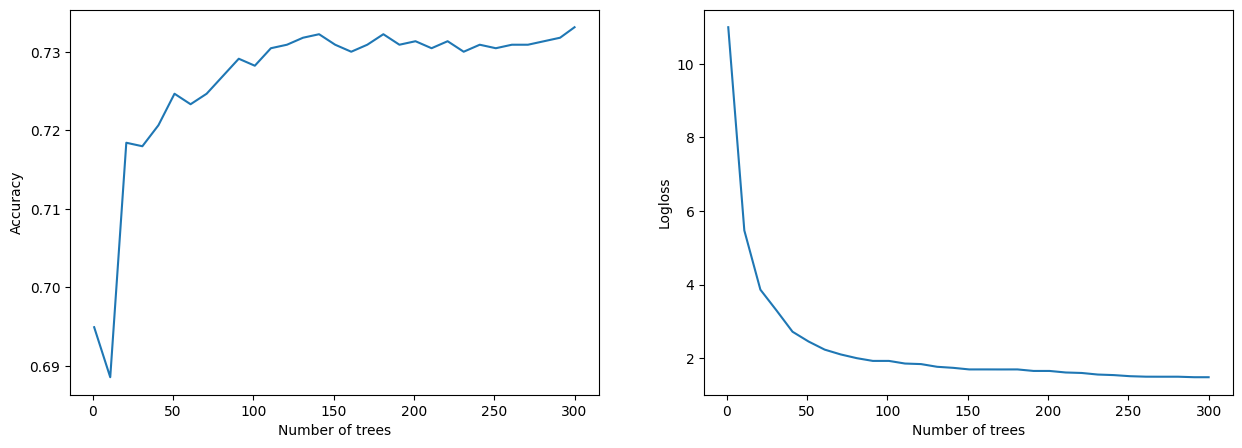

In [44]:
import matplotlib.pyplot as plt

logs = model.make_inspector().training_logs()

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss")

plt.show()

# Plot the model

In [45]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3)

# Save Model

In [46]:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/distribute/save_and_load.ipynb#scrollTo=jFcuzsI94bNA
#save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
# model.save(model_gs_path,options=save_options)
# model.save(model_local_path,options=save_options)
model.save(model_gs_path)

INFO:tensorflow:Assets written to: gs://demo-tuned-tf-incident-pongthorn/model_rf_tf/assets


INFO:tensorflow:Assets written to: gs://demo-tuned-tf-incident-pongthorn/model_rf_tf/assets
